In [35]:
import pandas, seaborn, scipy, numpy, matplotlib, collections, sklearn, math, seaborn
import sklearn.linear_model

%matplotlib inline
from matplotlib import pyplot

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

%matplotlib inline
%config InlineBackend.figure_format = 'png'

matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)
matplotlib.rc('text', usetex=True)
#reload(c)

pandas.set_option('display.max_rows', 50)
pandas.set_option('display.max_columns', 50)

def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')
    
def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0, plusminus=False, function=numpy.mean):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values, statistic=function)
    if numpy.nan in bars:
        return pattern % function(values)
    diff = (bars[1] - bars[0]) / 2
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2))
        diff = round_to_n(diff, 1)
    if plusminus:
        return (pattern + " $\\pm$ " + pattern) % (function(values), diff)
    return (pattern + " (" + pattern + "-" + pattern + ")") % ((function(values),) + bars)

def median_with_errorbars(values, decimals=0, plusminus=False, function=numpy.median):
    return mean_with_errorbars(values, decimals, plusminus, function)


In [2]:
sources_with_signature_counts = pandas.read_csv(
    "../data/derived/sources.extended.with_signature_counts.csv",
    index_col="source_id")

In [24]:
sources_with_signature_counts["specific_treatment"] = sources_with_signature_counts.specific_treatment.map(lambda x: {
        "adjuvant chemotherapy": "AMCT",
        "neoadjuvant chemotherapy": "NACT",
    }.get(x, x))
sources_with_signature_counts.specific_treatment

source_id
AOCS-001-1-7     treatment naive
AOCS-004-1-5     treatment naive
AOCS-005-1-8     treatment naive
AOCS-034-1-0     treatment naive
AOCS-034-3-8                AMCT
AOCS-055-1-7     treatment naive
AOCS-056-1-X     treatment naive
AOCS-057-1-2     treatment naive
AOCS-058-1-5     treatment naive
AOCS-059-1-8     treatment naive
AOCS-060-1-5     treatment naive
AOCS-061-1-8     treatment naive
AOCS-063-1-3     treatment naive
AOCS-064-1-6     treatment naive
AOCS-064-3-3                AMCT
AOCS-065-1-9     treatment naive
AOCS-065-3-6                AMCT
AOCS-075-1-0     treatment naive
AOCS-076-1-3     treatment naive
AOCS-077-1-6                NACT
AOCS-078-1-9     treatment naive
AOCS-079-1-1     treatment naive
AOCS-080-1-9     treatment naive
AOCS-081-1-1     treatment naive
AOCS-083-1-7     treatment naive
                      ...       
AOCS-149-1-7     treatment naive
AOCS-150-3-1                AMCT
AOCS-150-8-X                AMCT
AOCS-152-1-X     treatment naive


mutations treatment naive 104.752552144 [  2.05446356  12.61052693  33.71700952  18.8795367   30.64576027
   0.77760967   6.06764549]
mutations AMCT 105.491701586 [  6.43771735   5.39202824  42.51928223  16.91727575  27.25283787
   1.24078641   5.73177373]
mutations NACT 105.584109686 [  0.18471977  18.56607421  26.67509998  21.66211812  29.77794261
   0.67515182   8.04300318]
neoantigens treatment naive 98.9054987387 [  1.51034902  16.18861215  27.97398083  13.64421122  24.0532586
   0.94643646  14.58865045]
neoantigens AMCT 99.8340140265 [  4.97286512   7.71163496  36.79323078  13.40990086  23.08805805
   1.65550791  12.20281634]
neoantigens NACT 98.2694403056 [  0.07412644  19.633193    17.7073732   13.48784104  20.89028252
   0.52665694  25.94996715]
expressed neoantigens treatment naive 98.6658954564 [  1.66801335  17.60980139  33.13960966  15.39847824  29.04109954
   0.75656976   1.05232351]
expressed neoantigens AMCT 99.8069601746 [  5.05862168   9.11569171  41.39463335  13.7124

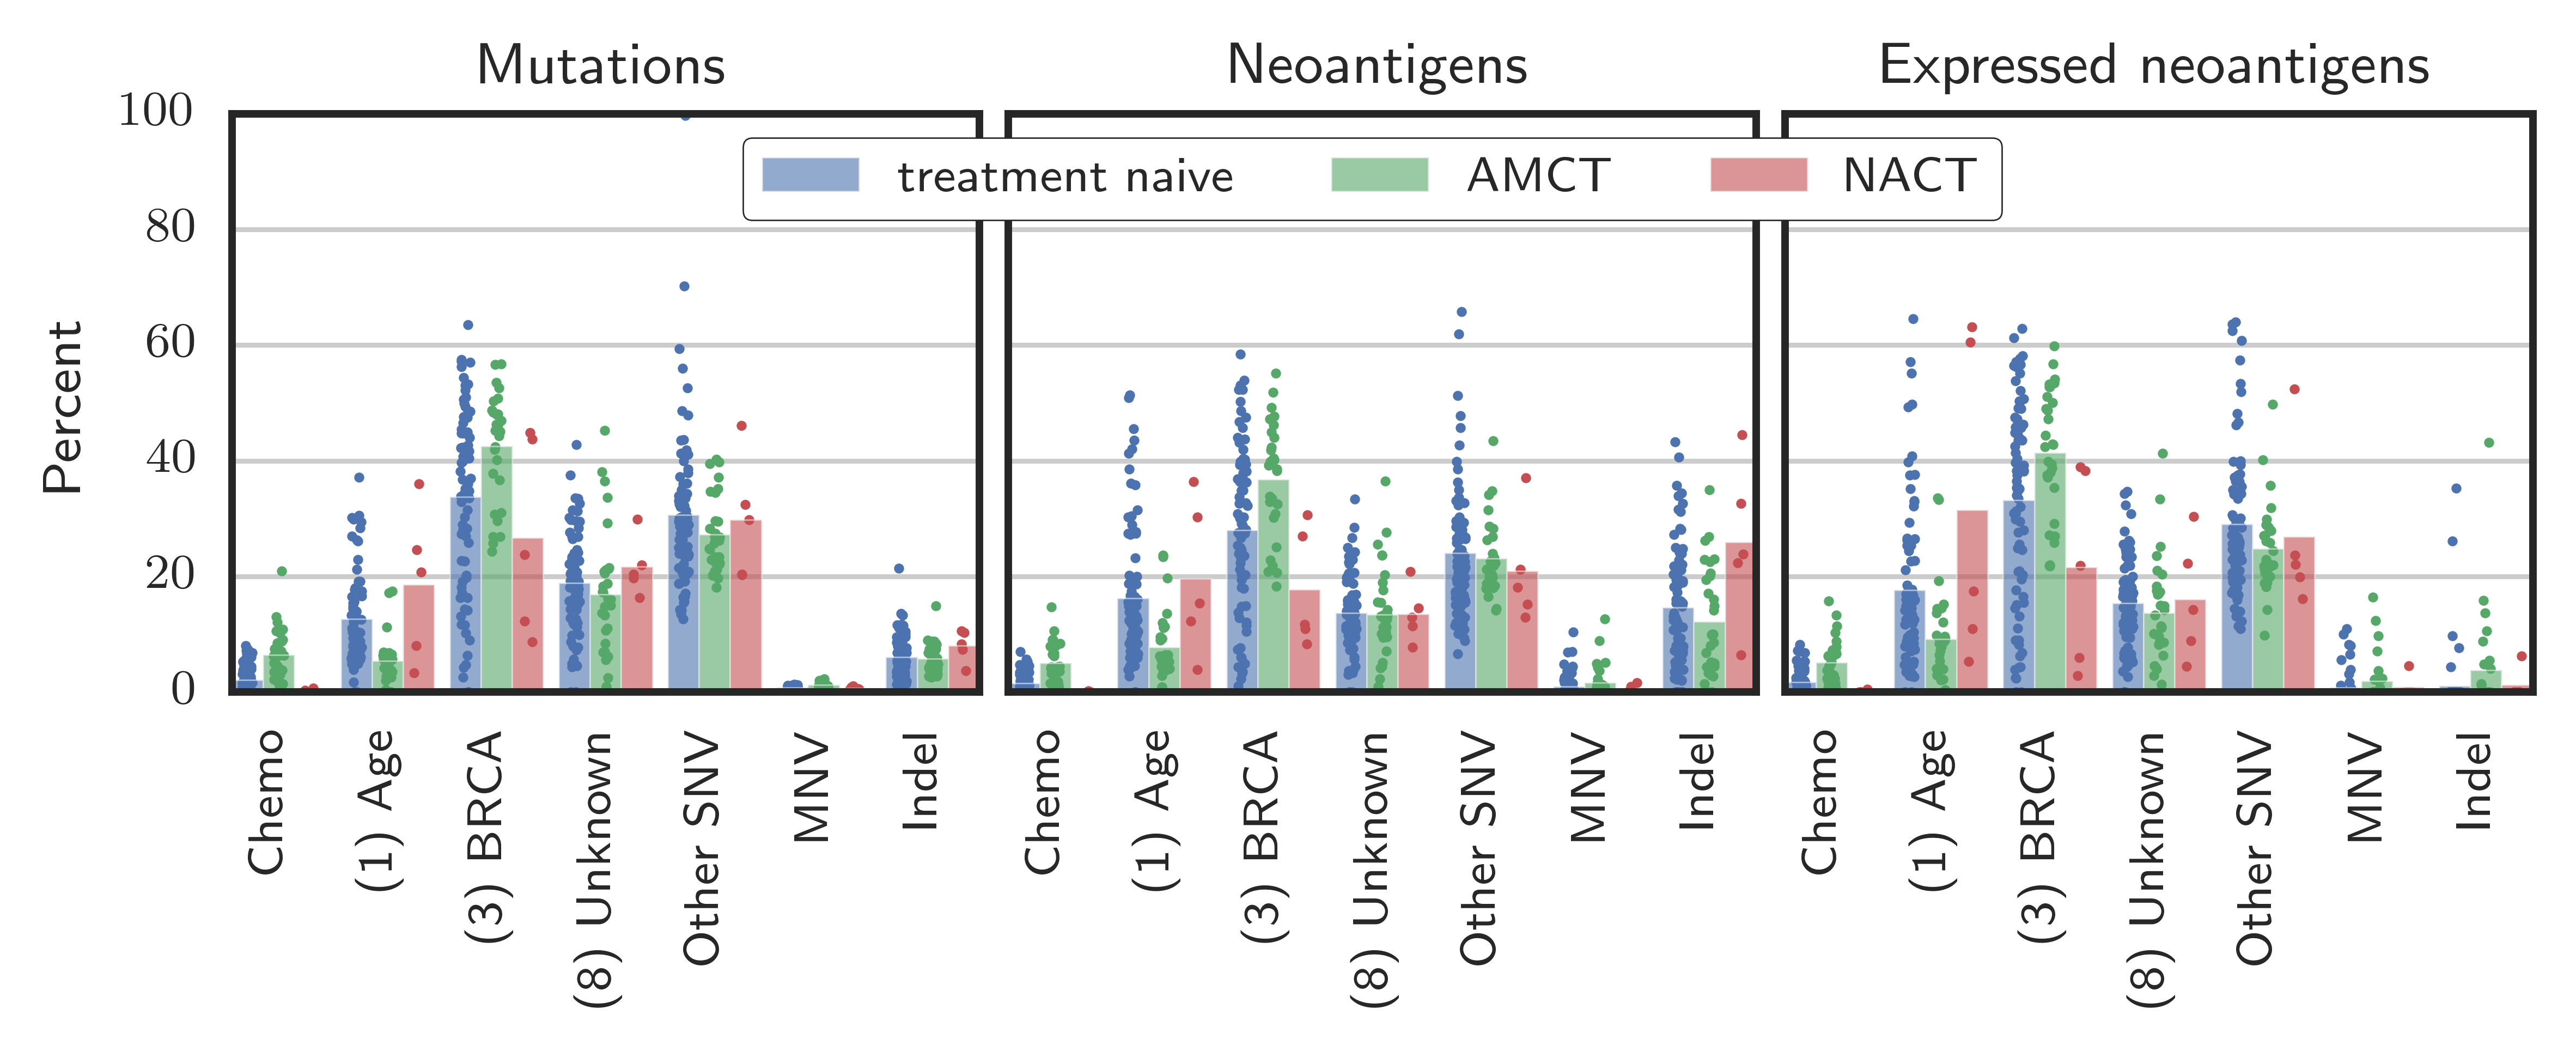

In [37]:
for key in ['mutations', 'neoantigens', 'expressed neoantigens']:
    sources_with_signature_counts["chemo %s" % key] = (
        sources_with_signature_counts["Cisplatin Gallus gallus %s" % key]
        + sources_with_signature_counts['Cyclophosphamide Gallus gallus %s' % key]
        + sources_with_signature_counts['Cisplatin C Elegans %s' % key]

        #+ sources_with_signature_counts['Cisplatin C Elegans fcd 2 %s' % key]
        #+ sources_with_signature_counts['Cisplatin C Elegans polq 1 %s' % key]
        #+ sources_with_signature_counts['Cisplatin C Elegans xpf 1 %s' % key]
    )

display_signatures = [
    "chemo",
    "Signature 1",
    "Signature 3",
    "Signature 8",
    "other snv",
  #  "residual",
    "mnv",
    "indel",
]

import itertools

def cleanup_name(col):
    return (
        col
        .replace("mnv", "MNV")
        .replace("mutations", "")
        .replace("neoantigens", "")
        .replace("other snv", "Other SNV")
        .replace("indel", "Indel")
        .replace("residual", "Unclassified")
        .replace("chemo", "Chemo")
        .replace("Signature 1", "(1) Age")
        .replace("Signature 3", "(3) BRCA")
        .replace("Signature 8", "(8) Unknown")
        .replace("expressed", "")
        .strip())

import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def jiggle(arr):
    return arr + (numpy.random.rand(len(arr)) - 0.5) / 3.0

def jiggle_order(x, y, width=0.8):
    percentiles = {}
    for some_x in set(x):
        y_to_index = dict(
            (v, i) for (i, v) in enumerate(
                sorted(
                    y_value for (x_value, y_value)
                    in zip(x,y) if some_x == x_value)))
        
        for (y_value, index) in y_to_index.items():
            percentiles[(some_x, y_value)] = float(index) / len(y_to_index)
    
    return [
        x_value + ((sigmoid(percentiles[(x_value, y_value)]) / sigmoid(1)) - width / 2) * width
        #x_value + (percentiles[(x_value, y_value)] - width / 2) * width
        for (x_value, y_value) in zip(x, y)
    ]

def plot_mutations_or_neoantigens(which):
    palette = itertools.cycle(seaborn.color_palette())
    cols = [x + " " + which for x in display_signatures]
    #masks = [
    #    ("pre-treatment", (~ sources_with_signature_counts.treated)),
    #    ("post-treatment", (sources_with_signature_counts.treated)),
    #]
    masks = [
        (name, sources_with_signature_counts.specific_treatment == name)
        for name in sources_with_signature_counts.specific_treatment.unique()
    ]
    offset = 0
    for (label, mask) in masks:
        label_sources = sources_with_signature_counts.ix[mask]
        xs = numpy.arange(len(cols)) * 3.5 + offset
        full_ys = numpy.array([label_sources[col] for col in cols]) * 100.0
        ys = numpy.mean(full_ys, axis=1)
        print(which, label, ys.sum(), ys)
        ranges = numpy.array([bootstrap(label_sources[col]) for col in cols]).T * 100.0
        error_low = ys - ranges[0]
        error_hi = ranges[1] - ys
        color = next(palette)
        pyplot.bar(
            xs,
            ys,
            #yerr=numpy.array([error_low, error_hi]),
            ecolor="grey",
            capsize=0,
            label=label,
            color=color,
            alpha=0.6,
            width=1.0)
        pyplot.scatter(
            #jiggle_order(
            #    numpy.array([xs + 0.5 for _ in range(full_ys.shape[1])]).flatten(),
            #    full_ys.T.flatten()),
            jiggle(numpy.array([xs + 0.5 for _ in range(full_ys.shape[1])]).flatten()),
            full_ys.T.flatten(),
            color=color,
            s=2.0)
        offset += 1
        
    pyplot.xticks(xs - .75, [cleanup_name(c) for c in cols], rotation=90)
    pyplot.ylim(ymin=0, ymax=100)
    pyplot.xlim(xmin=0, xmax=xs.max() + 1.0)


pyplot.figure(figsize=(6,2.5))
seaborn.set_context("paper")
seaborn.set_style('white')

pyplot.subplot(131)
plot_mutations_or_neoantigens("mutations")
pyplot.title("Mutations")
pyplot.ylabel("Percent")
pyplot.gca().yaxis.grid(True)

#for label in pyplot.gca().yaxis.get_ticklabels()[1::2]:
#    label.set_visible(False)
    
pyplot.subplot(132, sharey=pyplot.gca())
plot_mutations_or_neoantigens("neoantigens")
pyplot.title("Neoantigens")
pyplot.gca().yaxis.grid(True)
pyplot.gca().label_outer()

pyplot.subplot(133, sharey=pyplot.gca())
plot_mutations_or_neoantigens("expressed neoantigens")
pyplot.title("Expressed neoantigens")
pyplot.gca().yaxis.grid(True)
pyplot.gca().label_outer()

pyplot.subplot(131)
pyplot.gca().set_zorder(10)
legend = pyplot.legend(ncol=3, fancybox=True, frameon=True, fontsize='small', framealpha=1, bbox_to_anchor=(2.40, 1.0))
legend.get_frame().set_facecolor('white')
legend.set_zorder(200)

pyplot.tight_layout(w_pad=0.5)


pyplot.savefig("../figures/sources_of_mutations_and_neoantigens.pdf",
               bbox_extra_artists=(legend,),
               bbox_inches='tight')


mutations treatment naive 3.30492628583 [ 0.19775436  1.59793092  1.25046273  0.25877828]
mutations AMCT 6.61897866001 [ 0.99828038  4.5437217   0.18126131  0.89571527]
mutations NACT 2.54866772298 [ 0.06816968  0.06578954  2.36394795  0.05076054]
neoantigens treatment naive 2.60485028495 [ 0.19264694  1.09828358  1.09450126  0.21941851]
neoantigens AMCT 5.1388510984 [ 0.85656163  3.34863685  0.16598597  0.76766665]
neoantigens NACT 1.80468613243 [ 0.01118074  0.03193149  1.73055969  0.0310142 ]
expressed neoantigens treatment naive 3.00211789807 [ 0.26765827  1.12457625  1.33410454  0.27577884]
expressed neoantigens AMCT 5.25166150064 [ 0.79235764  3.56289733  0.19303983  0.7033667 ]
expressed neoantigens NACT 1.93809667357 [ 0.02312282  0.06879964  1.80358142  0.04259279]


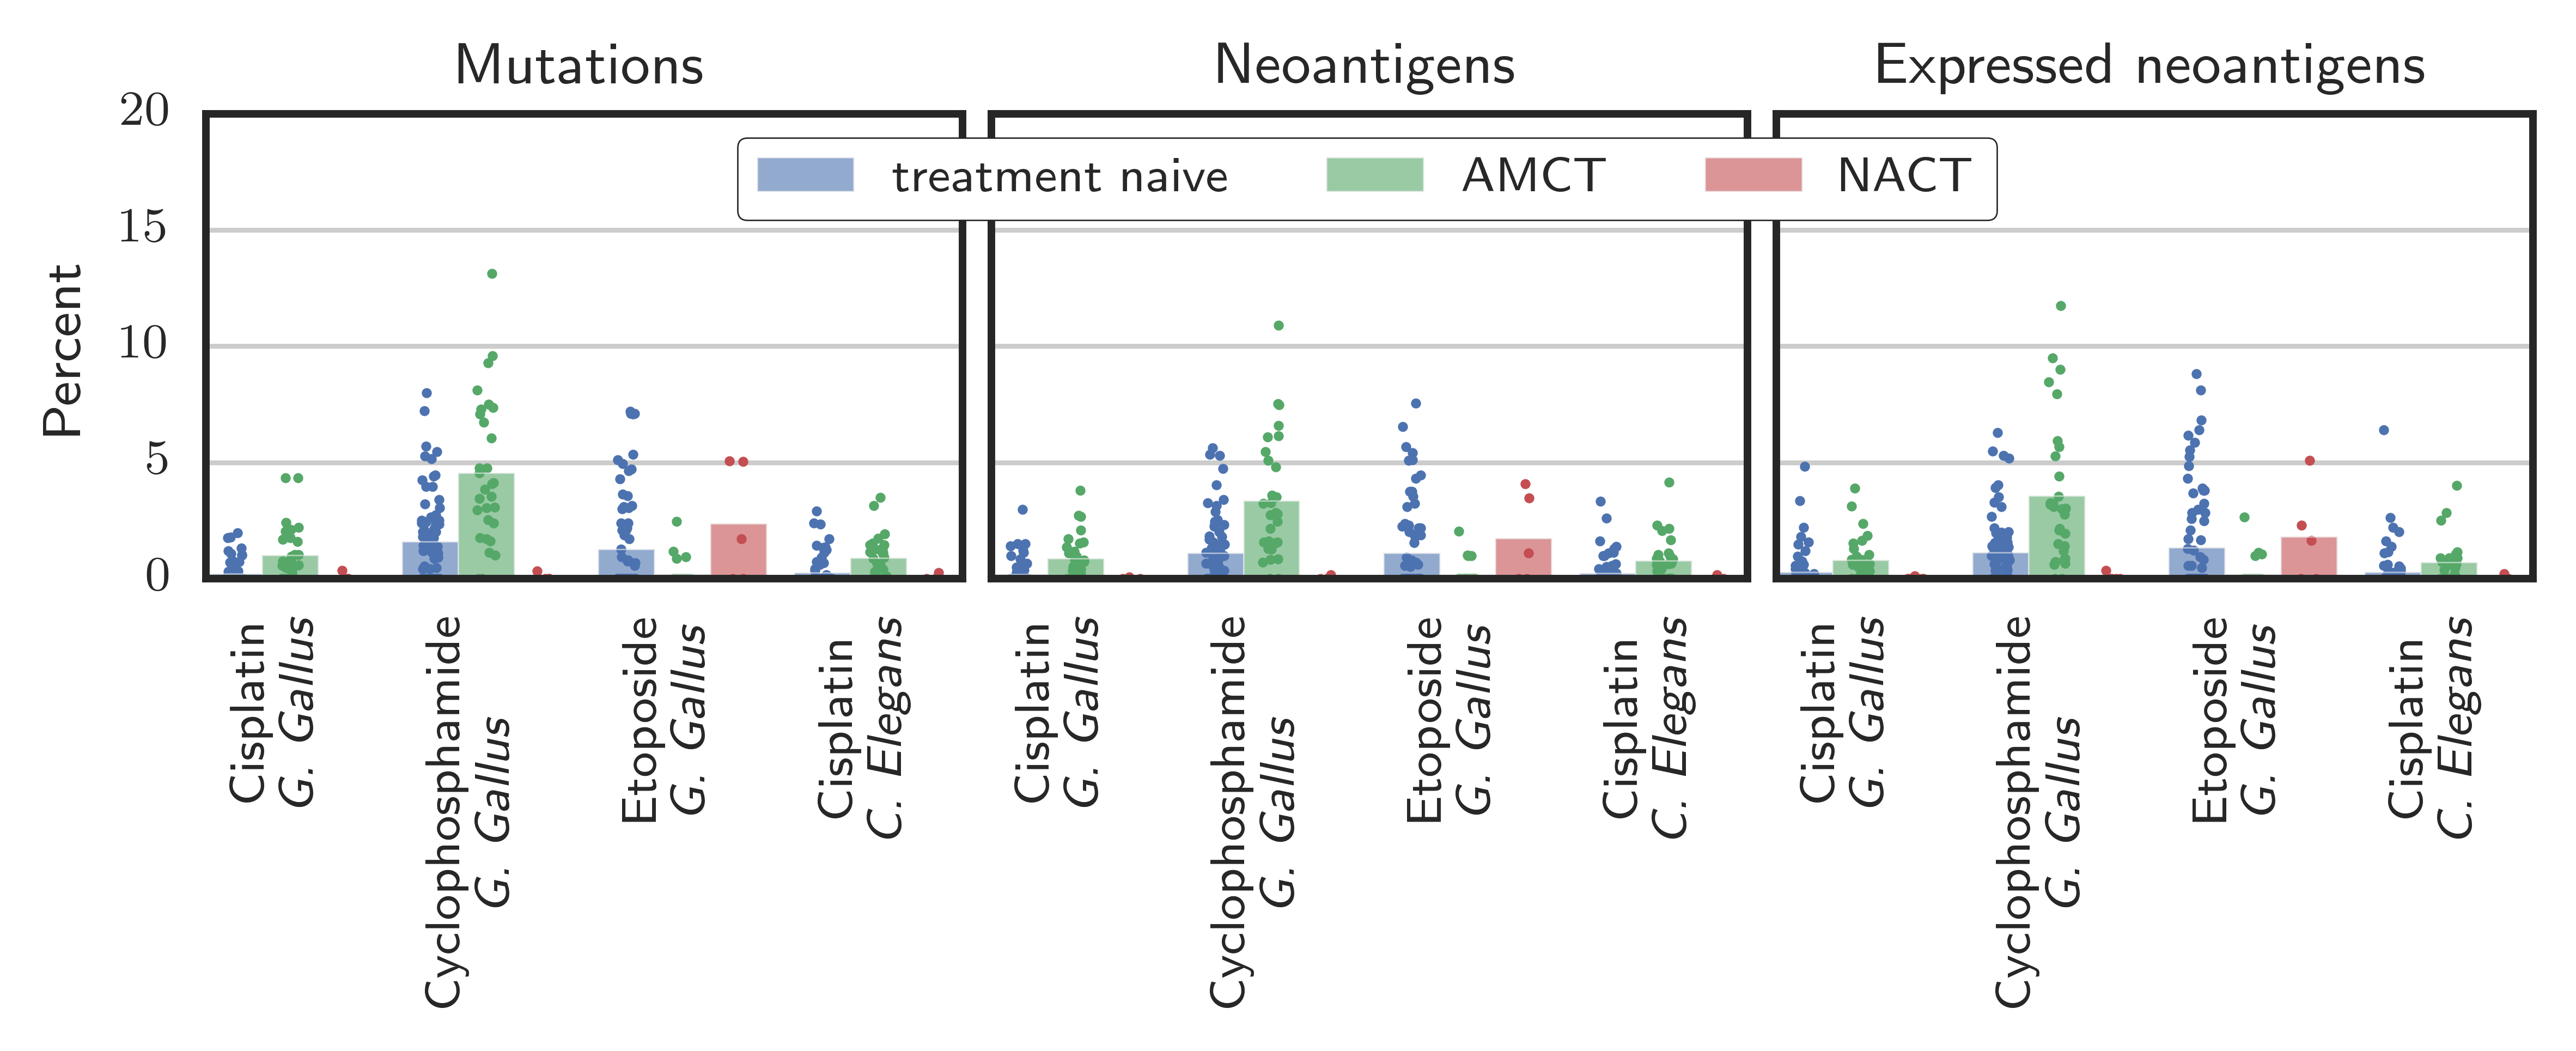

In [38]:
for key in ['mutations', 'neoantigens', 'expressed neoantigens']:
    sources_with_signature_counts["chemo %s" % key] = (
        sources_with_signature_counts["Cisplatin Gallus gallus %s" % key]
        + sources_with_signature_counts['Cyclophosphamide Gallus gallus %s' % key]
        + sources_with_signature_counts['Cisplatin C Elegans %s' % key]

        #+ sources_with_signature_counts['Cisplatin C Elegans fcd 2 %s' % key]
        #+ sources_with_signature_counts['Cisplatin C Elegans polq 1 %s' % key]
        #+ sources_with_signature_counts['Cisplatin C Elegans xpf 1 %s' % key]
    )

display_signatures = [
    'Cisplatin Gallus gallus',
    'Cyclophosphamide Gallus gallus',
    'Etoposide Gallus gallus',
    'Cisplatin C Elegans',
]
    
import itertools

def cleanup_name(col):
    return (
        col
        .replace("mnv", "MNV")
        .replace("mutations", "")
        .replace("neoantigens", "")
        .replace("other snv", "Other SNV")
        .replace("indel", "Indel")
        .replace("residual", "Unclassified")
        .replace("chemo", "Chemo")
        .replace("Signature 1", "(1) Age")
        .replace("Signature 3", "(3) BRCA")
        .replace("Signature 8", "(8) Unknown")
        .replace("expressed", "")
        .replace("C Elegans", "\n\\textit{C. Elegans}")
        .replace("Gallus gallus", "\n\\textit{G. Gallus}")
        #.replace("Cyclophosphamide", r"Cyc.")
        .strip())

import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def jiggle(arr):
    return arr + (numpy.random.rand(len(arr)) - 0.5) / 3.0

def jiggle_order(x, y, width=0.8):
    percentiles = {}
    for some_x in set(x):
        y_to_index = dict(
            (v, i) for (i, v) in enumerate(
                sorted(
                    y_value for (x_value, y_value)
                    in zip(x,y) if some_x == x_value)))
        
        for (y_value, index) in y_to_index.items():
            percentiles[(some_x, y_value)] = float(index) / len(y_to_index)
    
    return [
        x_value + ((sigmoid(percentiles[(x_value, y_value)]) / sigmoid(1)) - width / 2) * width
        #x_value + (percentiles[(x_value, y_value)] - width / 2) * width
        for (x_value, y_value) in zip(x, y)
    ]

def plot_mutations_or_neoantigens(which):
    palette = itertools.cycle(seaborn.color_palette())
    cols = [x + " " + which for x in display_signatures]
    #masks = [
    #    ("pre-treatment", (~ sources_with_signature_counts.treated)),
    #    ("post-treatment", (sources_with_signature_counts.treated)),
    #]
    masks = [
        (name, sources_with_signature_counts.specific_treatment == name)
        for name in sources_with_signature_counts.specific_treatment.unique()
    ]
    offset = 0
    for (label, mask) in masks:
        label_sources = sources_with_signature_counts.ix[mask]
        xs = numpy.arange(len(cols)) * 3.5 + offset
        full_ys = numpy.array([label_sources[col] for col in cols]) * 100.0
        ys = numpy.mean(full_ys, axis=1)
        print(which, label, ys.sum(), ys)
        ranges = numpy.array([bootstrap(label_sources[col]) for col in cols]).T * 100.0
        error_low = ys - ranges[0]
        error_hi = ranges[1] - ys
        color = next(palette)
        pyplot.bar(
            xs,
            ys,
            #yerr=numpy.array([error_low, error_hi]),
            ecolor="grey",
            capsize=0,
            label=label,
            color=color,
            alpha=0.6,
            width=1.0)
        pyplot.scatter(
            #jiggle_order(
            #    numpy.array([xs + 0.5 for _ in range(full_ys.shape[1])]).flatten(),
            #    full_ys.T.flatten()),
            jiggle(numpy.array([xs + 0.5 for _ in range(full_ys.shape[1])]).flatten()),
            full_ys.T.flatten(),
            color=color,
            s=2.0)
        offset += 1
        
    pyplot.xticks(xs - .75, [cleanup_name(c) for c in cols], rotation=90)
    pyplot.ylim(ymin=0, ymax=20)
    pyplot.xlim(xmin=0, xmax=xs.max() + 1.0)


pyplot.figure(figsize=(6,2.5))
seaborn.set_context("paper")
seaborn.set_style('white')

pyplot.subplot(131)
plot_mutations_or_neoantigens("mutations")
pyplot.title("Mutations")
pyplot.ylabel("Percent")
pyplot.gca().yaxis.grid(True)

#for label in pyplot.gca().yaxis.get_ticklabels()[1::2]:
#    label.set_visible(False)
    
pyplot.subplot(132, sharey=pyplot.gca())
plot_mutations_or_neoantigens("neoantigens")
pyplot.title("Neoantigens")
pyplot.gca().yaxis.grid(True)
pyplot.gca().label_outer()

pyplot.subplot(133, sharey=pyplot.gca())
plot_mutations_or_neoantigens("expressed neoantigens")
pyplot.title("Expressed neoantigens")
pyplot.gca().yaxis.grid(True)
pyplot.gca().label_outer()

pyplot.subplot(131)
pyplot.gca().set_zorder(10)
legend = pyplot.legend(ncol=3, fancybox=True, frameon=True, fontsize='small', framealpha=1, bbox_to_anchor=(2.40, 1.0))
legend.get_frame().set_facecolor('white')
legend.set_zorder(200)

pyplot.tight_layout(w_pad=0.5)


pyplot.savefig("../figures/sources_of_mutations_and_neoantigens_ungrouped.pdf",
               bbox_extra_artists=(legend,),
               bbox_inches='tight')


In [5]:
mean_with_errorbars([1,3,4])

'3 (2-4)'

In [6]:
sources_with_signature_counts.groupby("specific_treatment")["other snv mutations"].apply(
    lambda v: median_with_errorbars(v, decimals=2))

specific_treatment
adjuvant chemotherapy       0.26 (0.23-0.27)
neoadjuvant chemotherapy    0.30 (0.20-0.46)
treatment naive             0.29 (0.26-0.30)
Name: other snv mutations, dtype: object

In [7]:
sources_with_signature_counts.groupby("specific_treatment")["Signature 3 mutations"].apply(
    lambda v: median_with_errorbars(v, decimals=2))

specific_treatment
adjuvant chemotherapy       0.45 (0.42-0.48)
neoadjuvant chemotherapy    0.24 (0.09-0.45)
treatment naive             0.36 (0.34-0.41)
Name: Signature 3 mutations, dtype: object

In [8]:
sources_with_signature_counts.columns.tolist()
(
    sources_with_signature_counts["snv mutations"] *
    sources_with_signature_counts["chemo mutations"]).sort_values()

sources_with_signature_counts["snv mutations"]
record = sources_with_signature_counts.ix["AOCS-092-3-3"]

for kind in ["mutations", "neoantigens", "expressed neoantigens"]:
    print("%0.0f / %0.0f (%0.1f%%)" % (
            record["chemo %s" % kind] * record["snv %s" % kind],
            record["snv %s" % kind],
            record["chemo %s" % kind] * 100.0))
            

3243 / 15491 (20.9%)
9 / 61 (14.7%)
5 / 30 (15.7%)


In [9]:
sources_with_signature_counts[sources_with_signature_counts.columns.tolist()[-20:]].max()

Signature 8 neoantigens              3.649914e-01
Signature 8 expressed neoantigens    4.123628e-01
residual mutations                   1.357409e-15
residual neoantigens                 1.424621e-15
residual expressed neoantigens       1.672593e-15
other snv mutations                  9.964878e-01
other snv neoantigens                6.578947e-01
other snv expressed neoantigens      6.402878e-01
snv mutations                        3.858600e+04
snv neoantigens                      5.120000e+02
snv expressed neoantigens            2.270000e+02
mnv mutations                        2.233438e-02
mnv neoantigens                      1.267606e-01
mnv expressed neoantigens            1.636364e-01
indel mutations                      2.142857e-01
indel neoantigens                    4.444444e-01
indel expressed neoantigens          4.320988e-01
chemo mutations                      2.093707e-01
chemo neoantigens                    1.468978e-01
chemo expressed neoantigens          1.574012e-01


In [31]:
sources_with_signature_counts.columns.tolist()

['Unnamed: 0',
 'RNA_ID',
 'RNA biospecimen',
 'DNA_id',
 'DNA_biospecimen',
 'specimen_type_description',
 'CollectionPoint',
 'SpecimenType',
 'RNA data file',
 'DNA_sample_string',
 'icgc_sample_id',
 'project_code_x',
 'submitted_sample_id',
 'icgc_specimen_id',
 'submitted_specimen_id_x',
 'icgc_donor_id_x',
 'submitted_donor_id_x',
 'analyzed_sample_interval',
 'percentage_cellularity_x',
 'level_of_cellularity_x',
 'study',
 'project_code_y',
 'study_specimen_involved_in',
 'submitted_specimen_id_y',
 'icgc_donor_id_y',
 'submitted_donor_id_y',
 'specimen_type',
 'specimen_type_other',
 'specimen_interval',
 'specimen_donor_treatment_type',
 'specimen_donor_treatment_type_other',
 'specimen_processing',
 'specimen_storage',
 'tumour_confirmed',
 'tumour_histological_type',
 'tumour_grading_system',
 'tumour_grade',
 'tumour_stage_system',
 'tumour_stage',
 'percentage_cellularity_y',
 'level_of_cellularity_y',
 'cohort',
 'donor',
 'tissue_type',
 'timepoint',
 'treated',
 'meta

In [10]:
sources_with_signature_counts.ix[
    sources_with_signature_counts.index != "AOCS-092-3-3"][sources_with_signature_counts.columns.tolist()[-20:]].max()

Signature 8 neoantigens              3.649914e-01
Signature 8 expressed neoantigens    4.123628e-01
residual mutations                   1.357409e-15
residual neoantigens                 1.424621e-15
residual expressed neoantigens       1.672593e-15
other snv mutations                  9.964878e-01
other snv neoantigens                6.578947e-01
other snv expressed neoantigens      6.402878e-01
snv mutations                        3.858600e+04
snv neoantigens                      5.120000e+02
snv expressed neoantigens            2.270000e+02
mnv mutations                        2.000421e-02
mnv neoantigens                      1.041667e-01
mnv expressed neoantigens            1.636364e-01
indel mutations                      2.142857e-01
indel neoantigens                    4.444444e-01
indel expressed neoantigens          4.320988e-01
chemo mutations                      1.306247e-01
chemo neoantigens                    1.055289e-01
chemo expressed neoantigens          1.327007e-01


In [11]:
sources_with_signature_counts["classic mutations"] = ((
    sources_with_signature_counts["Signature 1 mutations"] +
    sources_with_signature_counts["Signature 3 mutations"] + 
    sources_with_signature_counts["Signature 8 mutations"]))
sources_with_signature_counts["classic neoantigens"] = ((
    sources_with_signature_counts["Signature 1 neoantigens"] +
    sources_with_signature_counts["Signature 3 neoantigens"] + 
    sources_with_signature_counts["Signature 8 neoantigens"]))
sources_with_signature_counts["classic expressed neoantigens"] = ((
    sources_with_signature_counts["Signature 1 expressed neoantigens"] +
    sources_with_signature_counts["Signature 3 expressed neoantigens"] + 
    sources_with_signature_counts["Signature 8 expressed neoantigens"]))

In [12]:
scipy.stats.mannwhitneyu(
    sources_with_signature_counts[sources_with_signature_counts.specific_treatment ==
    "treatment_naive"]["classic neoantigens"],
    sources_with_signature_counts[sources_with_signature_counts.specific_treatment ==
    "neoadjuvant_chemotherapy"]["classic neoantigens"])
        

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [13]:
sources_with_signature_counts.groupby("specific_treatment")["classic mutations"].apply(
    lambda x: mean_with_errorbars(x, decimals=2))

specific_treatment
adjuvant chemotherapy       0.65 (0.62-0.67)
neoadjuvant chemotherapy    0.67 (0.60-0.73)
treatment naive             0.65 (0.63-0.67)
Name: classic mutations, dtype: object

In [14]:
(
    median_with_errorbars(sources_with_signature_counts["classic mutations"], decimals=2),
    median_with_errorbars(sources_with_signature_counts["classic neoantigens"], decimals=2),
    median_with_errorbars(sources_with_signature_counts["classic expressed neoantigens"], decimals=2)
)

('0.67 (0.66-0.69)', '0.58 (0.56-0.61)', '0.68 (0.66-0.71)')

In [15]:
sources_with_signature_counts.groupby("specific_treatment")["classic mutations"].apply(
    lambda x: mean_with_errorbars(x, decimals=2))

mean_with_errorbars(sources_with_signature_counts["classic mutations"], decimals=2)
mean_with_errorbars(sources_with_signature_counts["classic neoantigens"], decimals=2)

'0.58 (0.56-0.59)'

In [16]:
sources_with_signature_counts.groupby("specific_treatment")["classic mutations"].mean()
sources_with_signature_counts.groupby("specific_treatment")["classic neoantigens"].mean()

specific_treatment
adjuvant chemotherapy       0.579148
neoadjuvant chemotherapy    0.508284
treatment naive             0.578068
Name: classic neoantigens, dtype: float64

In [17]:
sources_with_signature_counts.sort("classic mutations") #.iloc[0]

/Users/tim/miniconda3/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Unnamed: 0,RNA_ID,RNA biospecimen,DNA_id,DNA_biospecimen,specimen_type_description,CollectionPoint,SpecimenType,RNA data file,DNA_sample_string,icgc_sample_id,project_code_x,submitted_sample_id,icgc_specimen_id,submitted_specimen_id_x,icgc_donor_id_x,submitted_donor_id_x,analyzed_sample_interval,percentage_cellularity_x,level_of_cellularity_x,study,project_code_y,study_specimen_involved_in,submitted_specimen_id_y,icgc_donor_id_y,...,Signature 3 expressed neoantigens,Signature 8 mutations,Signature 8 neoantigens,Signature 8 expressed neoantigens,residual mutations,residual neoantigens,residual expressed neoantigens,other snv mutations,other snv neoantigens,other snv expressed neoantigens,snv mutations,snv neoantigens,snv expressed neoantigens,mnv mutations,mnv neoantigens,mnv expressed neoantigens,indel mutations,indel neoantigens,indel expressed neoantigens,chemo mutations,chemo neoantigens,chemo expressed neoantigens,classic mutations,classic neoantigens,classic expressed neoantigens
source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AOCS-166-1-2,104,EXTERNAOCS20140227008,AOCS-166-2-6,AOCS_166_ICGC_DBDE_20130904_020,AOCS-166-1-2,primary tumour,Primary,Tumour,140227_EXTERN_0128_AC2V5YACXX.nopd.AOCS_166_EX...,ICGCDBDE20130904020,SA505825,OV-AU,AOCS-166-1-2,SP102133,AOCS-166-1,DO46591,AOCS-166,5150.0,91.0,>81%,PCAWG,OV-AU,PCAWG,AOCS-166-1,DO46591,...,0.000000,0.000000,0.000000,0.000000,-6.372898e-16,-4.979325e-16,-8.607370e-16,0.996488,0.657895,0.640288,38586.0,275.0,89.0,0.002143,0.002392,0.007194,0.135897,0.339713,0.352518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AOCS-165-1-X,103,EXTERNAOCS20140227007,AOCS-165-2-3,AOCS_165_ICGC_DBDE_20130904_019,AOCS-165-1-X,primary tumour,Primary,Tumour,140227_EXTERN_0128_AC2V5YACXX.nopd.AOCS_165_EX...,ICGCDBDE20130904019,SA505809,OV-AU,AOCS-165-1-X,SP102123,AOCS-165-1,DO46588,AOCS-165,6206.0,84.0,>81%,PCAWG,OV-AU,PCAWG,AOCS-165-1,DO46588,...,0.000000,0.204689,0.158265,0.180285,9.835937e-16,1.394318e-15,1.255412e-15,0.701708,0.618846,0.635959,6183.0,136.0,61.0,0.004182,0.000000,0.000000,0.106667,0.074830,0.000000,0.012445,0.009747,0.016065,0.280378,0.296578,0.347976
AOCS-092-3-3,35,ICGCDBDE20131122028,AOCS-092-4-7,AOCS_092_ICGC_DBPC_20130205_059,AOCS-092-3-3,recurrent ascitic fluid,Recurrence,Ascites,131206_EXTERN_0045_AC2KJBACXX.nopd.AOCS_092_IC...,ICGCDBPC20130205059,SA505685,OV-AU,AOCS-092-3-3,SP101630,AOCS-092-13,DO46374,AOCS-092,63.0,89.0,>81%,NaN,OV-AU,NaN,AOCS-092-13,DO46374,...,0.371834,0.024287,0.022520,0.028864,-1.129366e-16,-1.163210e-16,-3.065265e-16,0.394689,0.314807,0.401840,15491.0,61.0,30.0,0.022334,0.126761,0.000000,0.027473,0.014085,0.000000,0.209371,0.146898,0.157401,0.373290,0.397450,0.440759
AOCS-055-1-7,5,ICGCDBDE20130916005,AOCS-055-2-0,AOCS_055_ICGC_DBPC_20130205_011,AOCS-055-1-7,primary tumour,Primary,Tumour,130906_D81P8DQ1_0153_C2704ACXX.nopd.AOCS_055_I...,ICGCDBPC20130205011,SA505316,OV-AU,AOCS-055-1-7,SP101526,AOCS-055-1,DO46330,AOCS-055,2150.0,82.0,>81%,PCAWG,OV-AU,PCAWG,AOCS-055-1,DO46330,...,0.208865,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.593488,0.512771,0.607863,14583.0,152.0,91.0,0.004165,0.000000,0.000000,0.013423,0.116279,0.000000,0.014213,0.009805,0.007598,0.381320,0.355575,0.379999
AOCS-085-1-2,26,ICGCDBDE20130916018,AOCS-085-2-6,AOCS_085_ICGC_DBPC_20130205_049,AOCS-085-1-2,primary tumour,Primary,Tumour,130906_D81P8DQ1_0158_D2B80ACXX.nopd.AOCS_085_I...,ICGCDBPC20130205049,SA505577,OV-AU,AOCS-085-1-2,SP101600,AOCS-085-1,DO46364,AOCS-085,1344.0,74.0,61-80%,PCAWG,OV-AU,PCAWG,AOCS-085-1,DO46364,...,0.042916,0.246132,0.160597,0.194034,-5.764568e-16,-4.610978e-16,-5.201197e-16,0.559730,0.478040,0.574108,2122.0,22.0,21.0,0.005618,0.000000,0.000000,0.111111,0.153846,0.000000,0.000000,0.000000,0.000000,0.411851,0.344491,0.397581
AOCS-005-1-8,2,ICGCDBDE20130916004,AOCS-005-2-1,AOCS_005_ICGC_DBPC_20130205_006,AOCS-005-1-8,primary tumour,Primary,Tumour,130906_D81P8DQ1_0157_C270DACXX.nopd.AOCS_005_I...,ICGCDBPC201302

In [18]:
(sources_with_signature_counts["classic mutations"] > 0.5).value_counts()
(sources_with_signature_counts["classic neoantigens"] > 0.5).value_counts()

True     88
False    26
Name: classic neoantigens, dtype: int64

In [19]:

((
    sources_with_signature_counts["Signature 1 neoantigens"] +
    sources_with_signature_counts["Signature 3 neoantigens"] + 
    sources_with_signature_counts["Signature 8 neoantigens"]) > 0.5).value_counts()


True     88
False    26
dtype: int64

/Users/tim/miniconda3/envs/py3k/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


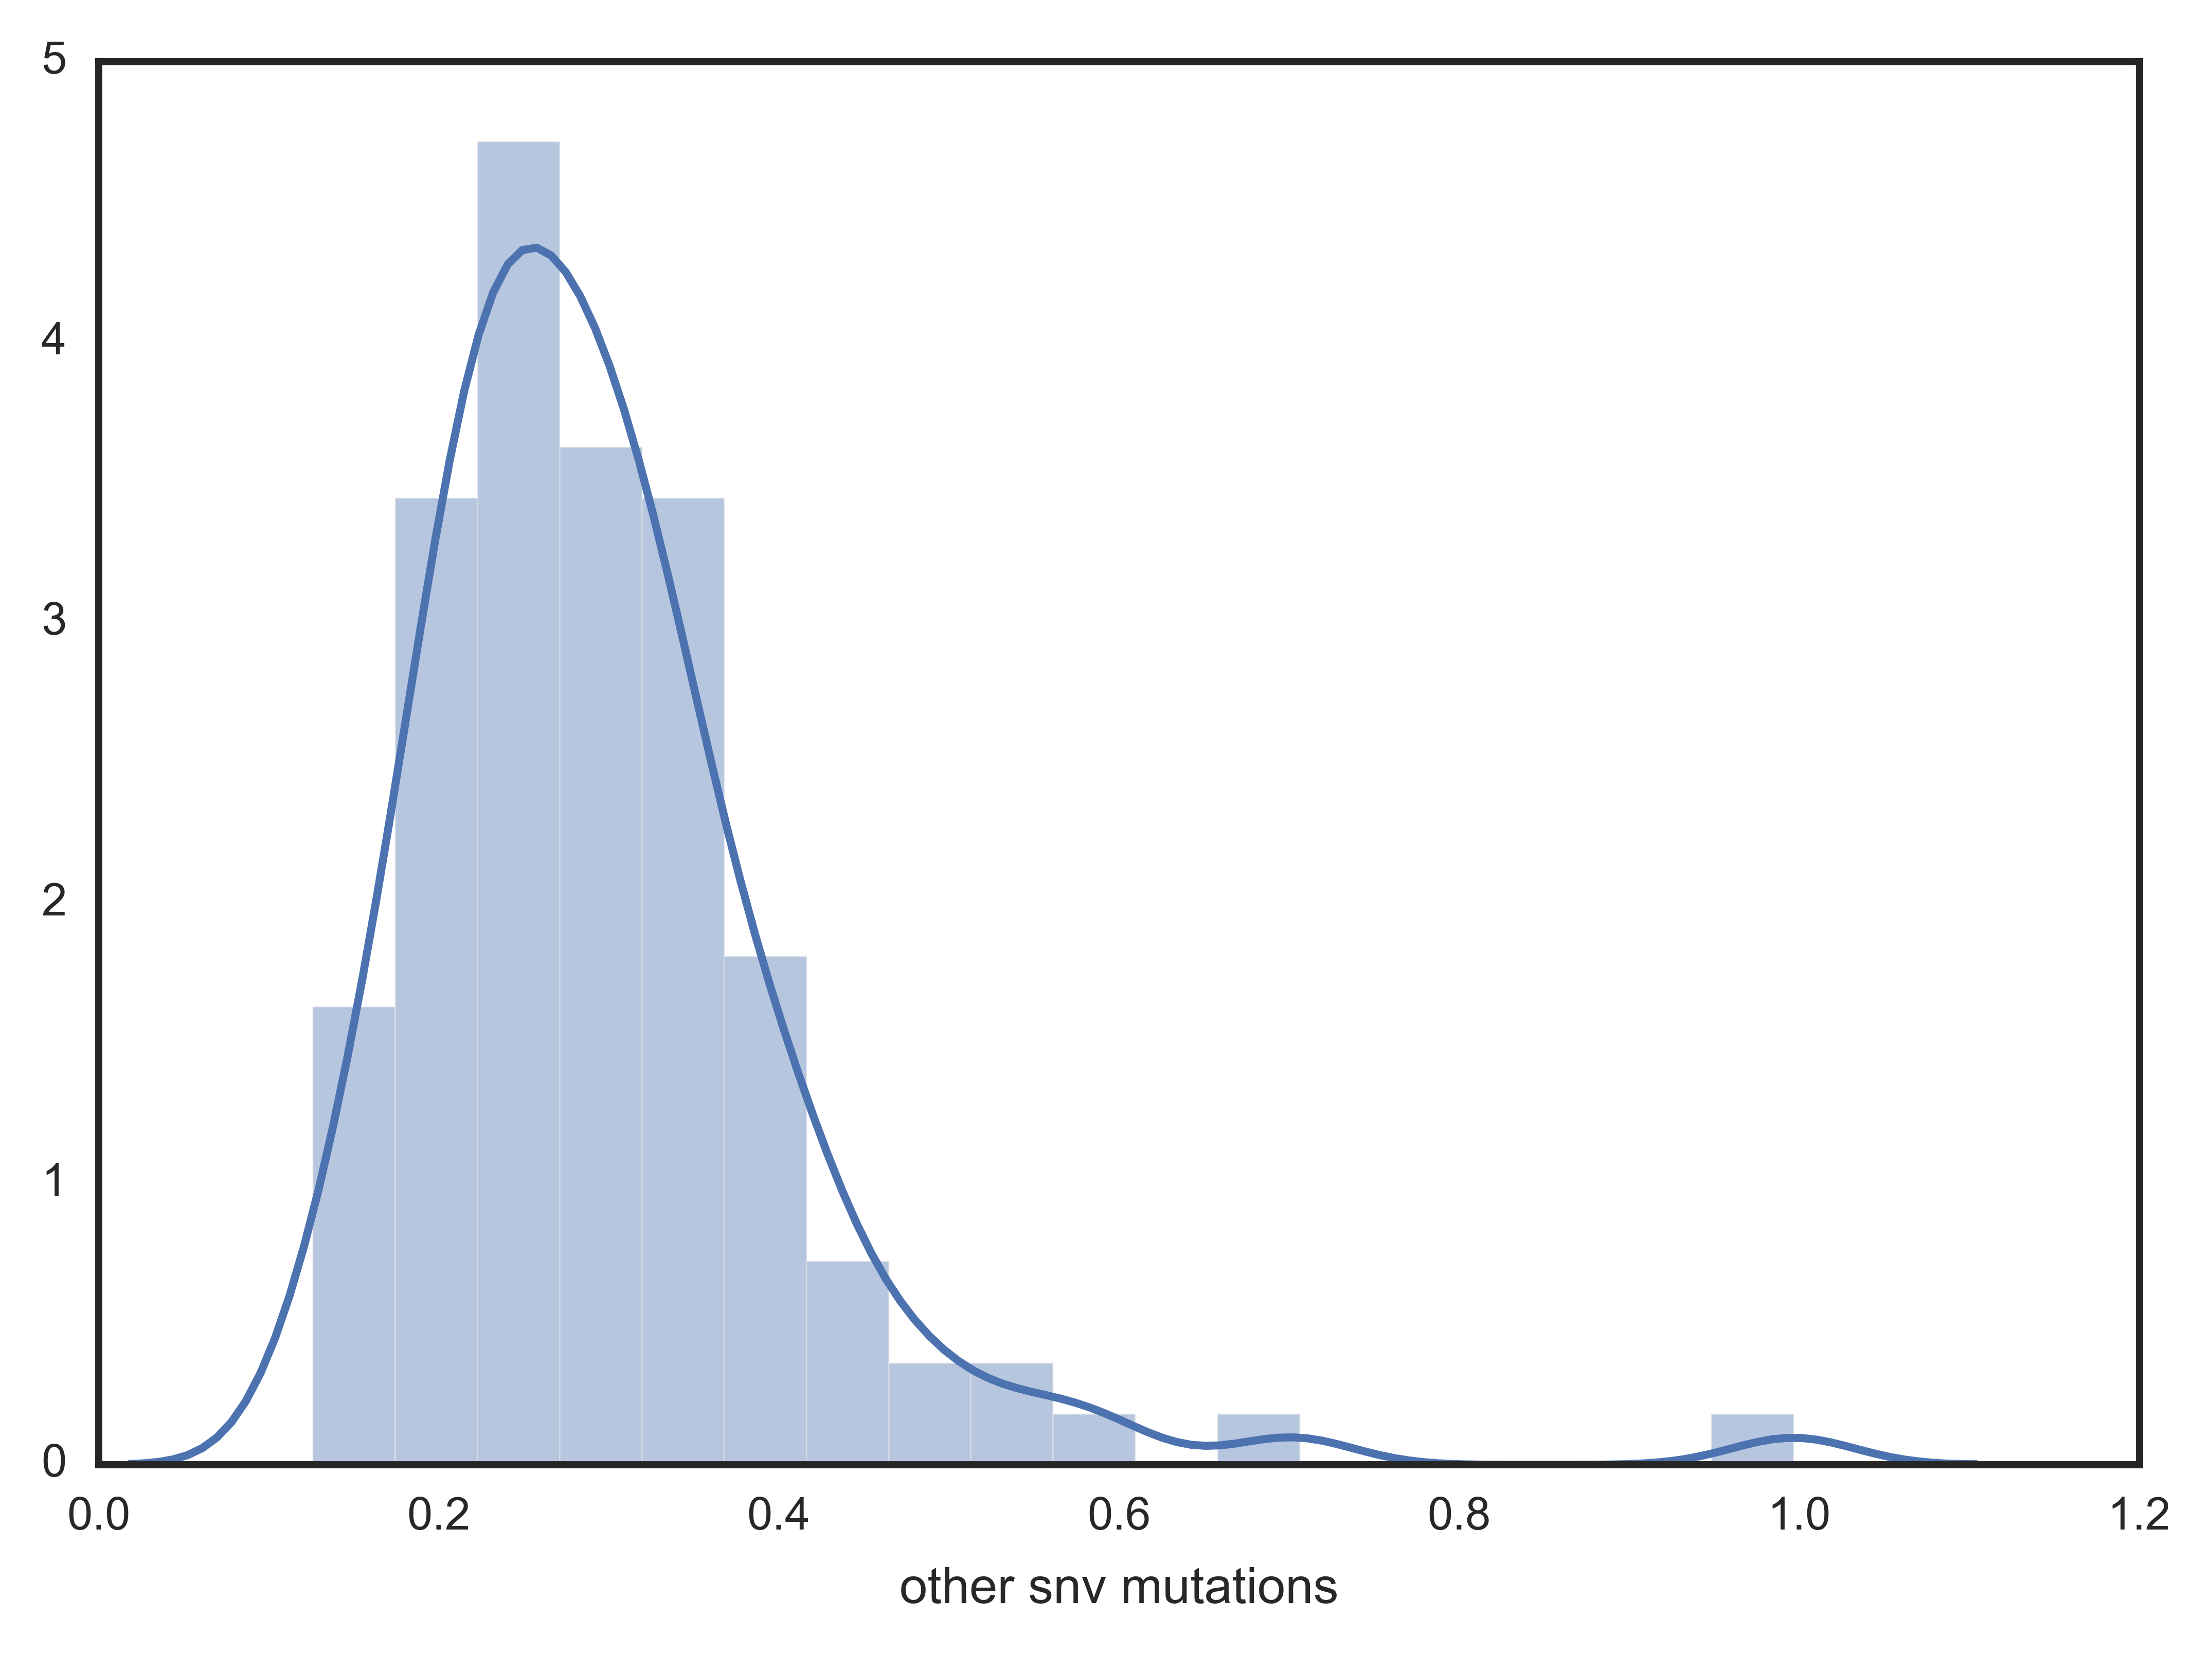

In [20]:
seaborn.distplot(sources_with_signature_counts["other snv mutations"])

In [21]:
#sources_with_signature_counts["classic mutations"]

In [22]:
#sources_with_signature_counts["chemo mutations"].sort_values()
#sources_with_signature_counts["chemo neoantigens"].sort_values()
sources_with_signature_counts["mnv mutations"].sort_values()
sources_with_signature_counts["mnv neoantigens"].sort_values()


source_id
AOCS-116-1-3     0.000000
AOCS-137-1-X     0.000000
AOCS-134-3-9     0.000000
AOCS-133-1-9     0.000000
AOCS-132-1-6     0.000000
AOCS-130-1-0     0.000000
AOCS-128-1-0     0.000000
AOCS-126-1-5     0.000000
AOCS-124-1-X     0.000000
AOCS-139-12-5    0.000000
AOCS-123-1-7     0.000000
AOCS-120-3-6     0.000000
AOCS-117-3-3     0.000000
AOCS-171-1-0     0.000000
AOCS-115-1-0     0.000000
AOCS-113-1-5     0.000000
AOCS-112-1-2     0.000000
AOCS-111-1-X     0.000000
AOCS-107-1-4     0.000000
AOCS-122-1-4     0.000000
AOCS-105-1-9     0.000000
AOCS-139-19-0    0.000000
AOCS-141-3-2     0.000000
AOCS-170-3-5     0.000000
AOCS-170-1-8     0.000000
                   ...   
AOCS-001-1-7     0.016393
AOCS-158-1-6     0.016529
AOCS-164-1-7     0.020408
AOCS-153-1-2     0.020548
AOCS-159-1-9     0.021739
AOCS-150-3-1     0.022472
AOCS-131-1-3     0.024590
AOCS-088-1-0     0.025641
AOCS-058-1-5     0.026846
AOCS-093-8-4     0.033582
AOCS-114-1-8     0.035088
AOCS-149-1-7     0.036364
AO

In [23]:
sources_with_signature_counts["chemo neoantigens"].median()


0.014800784481824307